# `moscot-spatial mapping`scRNAseq using MERFISH reference data using

We use MERFISH on mouse liver and kidney tissues obtained using the Vizgen MERSCOPE platform provided in [[1]](https://doi.org/10.1101/2022.03.04.483068)  

[[1] Liu, Jonathan, Vanessa Tran, Venkata Naga Pranathi Vemuri, Ashley Byrne, Michael Borja, Snigdha Agarwal, Ruofan Wang et al. "Comparative analysis of MERFISH spatial transcriptomics with bulk and single-cell RNA sequencing." bioRxiv (2022).](https://doi.org/10.1101/2022.03.04.483068)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.insert(0, 
                '{}/lib/python{}.{}/site-packages'.format(sys.prefix,sys.version_info.major, sys.version_info.minor))


In [3]:
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
sys.path.append("/cs/labs/mornitzan/zoe.piran/research/projects/moscot_framework_analysis/data/merfish")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

import anndata
import seaborn as sns
import matplotlib as mpl

from matplotlib.lines import Line2D
import string

In [5]:
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
module_path = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(os.path.join('..')))))
sys.path.append(os.path.join(module_path, 'moscot'))
sys.path.append(os.path.join(module_path, 'moscot_framework_analysis/experiments/spatial_mapping'))

DATA_DIR = '/cs/labs/mornitzan/zoe.piran/research/projects/moscot_framework_analysis/data/merfish/'


In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

from ott.geometry.geometry import Geometry
from jax import numpy as jnp
from typing import Optional
import jax
from jax.interpreters import xla

# jax.config.update('jax_platform_name', 'cpu')
from moscot.problems.space import MappingProblem

import ott

### Set parameters

In [7]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_style("whitegrid", {'xtick.direction': 'out', 'xtick.major.size': 3.0, 'xtick.minor.size': 3.0,
    'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 3.0, 'ytick.minor.size': 3.0, 
                           'font': ['DejaVu Sans'], 'font.scale': 1})

In [8]:
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
def set_plotting_style_huge():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=24)
    plt.rc('axes', titlesize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=20)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=4)
    plt.rc('ytick.major', pad=4)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    



### Import data

code adapted from original publication [Figs6_7_spatialintegration_plotresults.ipynb](https://github.com/czbiohub/MERFISH-mouse-comparison/blob/main/notebooks/figures/Figs6_7_spatialintegration_plotresults.ipynb)

In [9]:
## MERFISH data
adata_spatial = {"kidney": sc.read(DATA_DIR + "MERFISH_kidney_object.h5ad"),
                 "liver": sc.read(DATA_DIR + "MERFISH_liver_object.h5ad")}
adata_scANVI = {"kidney": sc.read(DATA_DIR + "scANVI_kidney_object.h5ad"),
                "liver": sc.read(DATA_DIR + "scANVI_liver_object.h5ad")} 

## MERFISH+scRNA-seq data
adata_scVI = {"kidney": sc.read(DATA_DIR + "scVI_kidney_object.h5ad"),
              "liver": sc.read(DATA_DIR + "scVI_liver_object.h5ad")}

In [10]:
liver_concat = sc.read_h5ad(DATA_DIR + 'scVI_liver_object.h5ad')
kidney_concat = sc.read_h5ad(DATA_DIR + 'scVI_kidney_object.h5ad')
scanvi_liver = sc.read_h5ad(DATA_DIR + 'scANVI_liver_object.h5ad')
scanvi_kidney = sc.read_h5ad(DATA_DIR + 'scANVI_kidney_object.h5ad')
VizgenLiver = sc.read_h5ad(DATA_DIR + 'MERFISH_liver_object.h5ad')
VizgenKidney = sc.read_h5ad(DATA_DIR + 'MERFISH_kidney_object.h5ad')

In [11]:
# Rotate coordinates for liver to make the aspect ratio nicer
scanvi_liver.obsm['spatial'] = scanvi_liver.obsm['spatial'][:,[1,0]].copy()
VizgenLiver.obsm['spatial'] = VizgenLiver.obsm['spatial'][:,[1,0]].copy()

# Remap cell type labels to coarse groups
liver_relabel_map = {'B cell': 'immune cell',
                    'NK cell': 'immune cell',
                    'periportal endothelial cell': 'periportal endothelial cell',
                    'pericentral endothelial cell': 'pericentral endothelial cell',
                    'other endothelial cell': 'other endothelial cell',
                    'myeloid leukocyte': 'immune cell',
                    'plasmacytoid dendritic cell': 'immune cell',
                    'Kupffer cell': 'Kupffer cell',
                    'hepatic stellate cell': 'hepatic stellate cell',
                    'other hepatocyte': 'other hepatocyte',
                    'periportal hepatocyte': 'periportal hepatocyte',
                    'pericentral hepatocyte': 'pericentral hepatocyte'}
kidney_relabel_map = {'macrophage': 'immune cell',
                     'lymphocyte': 'immune cell',
                     'glomerular capillary endothelial cell': 'endothelial cell',
                     'kidney blood vessel cell': 'endothelial cell',
                     'plasma cell': 'immune cell',
                     'epithelial cell of proximal tubule': 'epithelial cell of proximal tubule',
                     'kidney loop of Henle epithelial cell': 'kidney loop of Henle epithelial cell',
                     'kidney distal convoluted tubule epithelial cell': 'kidney distal convoluted tubule epithelial cell',
                     'kidney collecting duct epithelial cell': 'kidney collecting duct epithelial cell',
                     'pericyte': 'pericyte',
                     'podocyte': 'podocyte',
                     'fibroblast': 'fibroblast'}

liver_concat.obs['predicted_cell_type'] = liver_concat.obs['predicted_cell_type'].map(liver_relabel_map)
scanvi_liver.obs['predicted_cell_type'] = scanvi_liver.obs['predicted_cell_type'].map(liver_relabel_map)
kidney_concat.obs['predicted_cell_type'] = kidney_concat.obs['predicted_cell_type'].map(kidney_relabel_map)
scanvi_kidney.obs['predicted_cell_type'] = scanvi_kidney.obs['predicted_cell_type'].map(kidney_relabel_map)

# Create abbreviated cell type labels
liver_abbrev_map = {'immune cell': 'IC',
                   'other endothelial cell': 'o-EC',
                   'Kupffer cell': 'KC',
                   'hepatic stellate cell': 'HSC',
                   'other hepatocyte': 'o-hep',
                   'periportal hepatocyte': 'PP-hep',
                   'pericentral hepatocyte': 'PC-hep',
                   'periportal endothelial cell': 'PP-EC',
                   'pericentral endothelial cell': 'PC-EC'}
kidney_abbrev_map = {'epithelial cell of proximal tubule':'EC-PT',
                    'immune cell': 'IC',
                    'pericyte':'per',
                    'kidney loop of Henle epithelial cell':'KLH-EC',
                    'kidney collecting duct epithelial cell':'KCD-EC',
                    'kidney distal convoluted tubule epithelial cell':'KDCT-EC',
                    'endothelial cell': 'EC',
                    'podocyte':'pod',
                    'fibroblast':'fib'}

liver_concat.obs['predicted_cell_type_abv'] = liver_concat.obs['predicted_cell_type'].map(liver_abbrev_map)
scanvi_liver.obs['predicted_cell_type_abv'] = scanvi_liver.obs['predicted_cell_type'].map(liver_abbrev_map)
VizgenLiver.obs['tentative_annot_abv'] = VizgenLiver.obs['tentative_annot'].map(liver_abbrev_map)
kidney_concat.obs['predicted_cell_type_abv'] = kidney_concat.obs['predicted_cell_type'].map(kidney_abbrev_map)
scanvi_kidney.obs['predicted_cell_type_abv'] = scanvi_kidney.obs['predicted_cell_type'].map(kidney_abbrev_map)
VizgenKidney.obs['tentative_annot_abv'] = VizgenKidney.obs['tentative_annot'].map(kidney_abbrev_map)

print('Results loaded.')

Results loaded.


## Apply mapping

In [12]:
alpha = 0.5
epsilon = 1e-3

In [13]:
adata_sc_liver = liver_concat[liver_concat.obs["tech"] == "scRNA-seq"]
adata_spatial_liver = VizgenLiver.copy()

In [14]:
var_names = adata_spatial_liver.var_names[adata_spatial_liver.var_names.isin(adata_sc_liver.var_names)]

In [15]:
prob = MappingProblem(adata_sc = adata_sc_liver,
                      adata_spatial = adata_spatial_liver,
                      var_names = var_names,).prepare(sc_attr={"attr":"obsm", "key":"X_scANVI"},
                                                      spatial_key="spatial",
                                                      joint_attr = {"x_attr": "X", "y_attr": "X"}
                                                     )


In [16]:
prob.solve(alpha=alpha, epsilon=epsilon, scale_cost="max_cost")

In [31]:
adata_impute_liver = prob.impute()

In [53]:
adata_impute_liver.var_names

Index(['sox17', 'zap70', 'slc40a1', 'sdpr', 'cxcr2', 'des', 'scg2', 'marco',
       'faim3', 'prelp',
       ...
       'ccr2', 'pcsk1n', 'cybb', 'cfp', 'bgn', 'f8', 'vsig4', 'tmem27', 'ace2',
       'tlr7'],
      dtype='object', length=306)

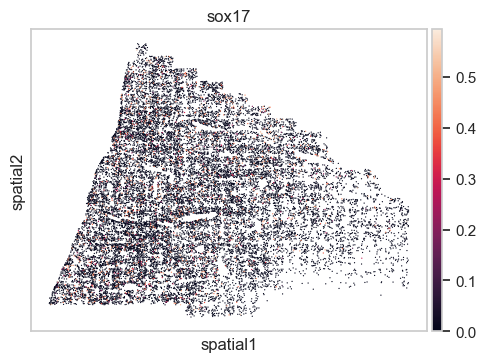

In [55]:
sc.pl.spatial(adata_impute_liver, color="sox17", spot_size=20)

In [50]:
corr_dict = prob.correlate()

/cs/labs/mornitzan/zoe.piran/venvSiFT/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [52]:
corr_dict[('src', 'ref')].mean()

0.26332458034549056